In [1]:
import keras
print(keras.__version__)

fashion_mnist = keras.datasets.fashion_mnist
(X_train, y_train), (X_test, y_test) = fashion_mnist.load_data()

2.4.3


In [2]:
from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin


class ImageFloatConverter(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        from skimage import img_as_float 
        import numpy as np
    
        X_ = np.zeros(X.shape, dtype=np.float)
        for i in range(X.shape[0]):
            X_[i] = img_as_float(X[i])
        return X_
    
scaler = ImageFloatConverter()
x = scaler.transform(X_train)



In [3]:
import numpy as np

# Test scaler max deviation
np.max(np.abs(x[42] * 255 - X_train[42]))

2.842170943040401e-14

In [4]:
class ImageAsSerial(BaseEstimator, TransformerMixin):
    def __init__(self):
        pass
    
    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        import numpy as np
        X_ = np.zeros((X.shape[0], X.shape[1] * X.shape[2]), dtype=np.float)
        for i in range(X.shape[0]):
            X_[i] = X[i].ravel()
        return X_

In [8]:
# Test that the Pipeline is working - not necessary to run.

from sklearn.linear_model import SGDClassifier

pipe = Pipeline([
    ('ImageFloatConverter', ImageFloatConverter()),
    ('Serialize', ImageAsSerial()),
    ('SGDClassifier', SGDClassifier(max_iter=100, tol=1e-3))])


pipe.fit(X_train, y_train)

Pipeline(steps=[('ImageFloatConverter', ImageFloatConverter()),
                ('Serialize', ImageAsSerial()),
                ('SGDClassifier', SGDClassifier(max_iter=100))])

In [9]:
pipe.score(X_test, y_test)

0.8327

# Test af modeller

In [10]:
from sklearn.linear_model import SGDClassifier

model = Pipeline([
                ('ImageFloatConverter', ImageFloatConverter()),
                ('Serialize', ImageAsSerial()),
                ('SGDClassifier', SGDClassifier(max_iter=100, tol=1e-3))]
            )
            
model.fit(X_train, y_train)
sgd_score = model.score(X_test, y_test)
print(sgd_score)

0.8294


In [11]:
from sklearn.svm import LinearSVC

model = Pipeline([
                ('ImageFloatConverter', ImageFloatConverter()),
                ('Serialize', ImageAsSerial()),
                ('LinearSVC', LinearSVC())]
            )
            
model.fit(X_train, y_train)
lsvc_score = model.score(X_test, y_test)
print(lsvc_score)

/home/morten/.local/lib/python3.8/site-packages/sklearn/svm/_base.py:985: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn("Liblinear failed to converge, increase "
0.8396


In [12]:
from sklearn.neighbors import KNeighborsClassifier
model = Pipeline([
                ('ImageFloatConverter', ImageFloatConverter()),
                ('Serialize', ImageAsSerial()),
                ('KNeighborsClassifier', KNeighborsClassifier())]
            )

model.fit(X_train, y_train)
knn_score = model.score(X_test, y_test)
print(knn_score)

0.8554


In [43]:
from sklearn.neural_network import MLPClassifier

model = Pipeline([
                ('ImageFloatConverter', ImageFloatConverter()),
                ('Serialize', ImageAsSerial()),
                ('MLPClassifier', MLPClassifier())]
            )

model.fit(X_train, y_train)
mlp_score = model.score(X_test, y_test)
print(mlp_score)

/home/morten/.local/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:619: UserWarning: Training interrupted by user.
  warnings.warn("Training interrupted by user.")
0.8783


In [14]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical

# SOURCE: https://machinelearningmastery.com/how-to-develop-a-cnn-from-scratch-for-fashion-mnist-clothing-classification/

# load train and test dataset
def load_dataset():
	# load dataset
	(trainX, trainY), (testX, testY) = fashion_mnist.load_data()
	# reshape dataset to have a single channel
	trainX = trainX.reshape((trainX.shape[0], 28, 28, 1))
	testX = testX.reshape((testX.shape[0], 28, 28, 1))
	# one hot encode target values
	trainY = to_categorical(trainY)
	testY = to_categorical(testY)
	return trainX, trainY, testX, testY

# scale pixels
def prep_pixels(train, test):
	# convert from integers to floats
	train_norm = train.astype('float32')
	test_norm = test.astype('float32')
	# normalize to range 0-1
	train_norm = train_norm / 255.0
	test_norm = test_norm / 255.0
	# return normalized images
	return train_norm, test_norm

# define cnn model
def define_model():
	model = Sequential()
	model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', input_shape=(28, 28, 1)))
	model.add(MaxPooling2D((2, 2)))
	model.add(Flatten())
	model.add(Dense(100, activation='relu', kernel_initializer='he_uniform'))
	model.add(Dense(10, activation='softmax'))
	# compile model
	opt = SGD(lr=0.01, momentum=0.9)
	model.compile(optimizer=opt, loss='categorical_crossentropy', metrics=['accuracy'])
	return model

trainX, trainY, testX, testY = load_dataset()
trainX, testX = prep_pixels(trainX, testX)
model = define_model()
model.fit(trainX, trainY)
eval = model.evaluate(testX, testY)

313/313 [==============================] - 1s 4ms/step - loss: 0.3250 - accuracy: 0.8837


In [16]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 32)        320       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 5408)              0         
_________________________________________________________________
dense (Dense)                (None, 100)               540900    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                1010      
Total params: 542,230
Trainable params: 542,230
Non-trainable params: 0
_________________________________________________________________


In [17]:
scores = {} # Reset
attempt = 0

In [41]:
import keras
from keras import layers

model = keras.Sequential()

model.add(layers.Conv2D(filters=32, kernel_size=(3,3),
                        activation='relu', input_shape=(28, 28, 1)))
model.add(layers.AveragePooling2D()) # 14x14 img

model.add(layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'))
model.add(layers.AveragePooling2D()) # 7x7 img

model.add(layers.Flatten())

model.add(layers.Dense(units=120, activation='relu'))
model.add(layers.Dense(units=84, activation='relu'))
model.add(layers.Dense(units=10, activation='softmax'))

#model.summary()

X_tmp = X_train.reshape((X_train.shape[0], 28, 28, 1))
y_tmp = to_categorical(y_train)
X_tmp_test = X_test.reshape((X_test.shape[0], 28, 28, 1))
y_tmp_test = to_categorical(y_test)

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics='accuracy')
model.fit(X_tmp, y_tmp, epochs=5)
eval = model.evaluate(X_tmp_test, y_tmp_test)
scores[f'attempt{attempt}'] = eval
attempt = attempt + 1

Epoch 1/5
1875/1875 [==============================] - 42s 22ms/step - loss: 0.7512 - accuracy: 0.7652
Epoch 2/5
1875/1875 [==============================] - 32s 17ms/step - loss: 0.3603 - accuracy: 0.8637
Epoch 3/5
1875/1875 [==============================] - 29s 15ms/step - loss: 0.3078 - accuracy: 0.8871
Epoch 4/5
1875/1875 [==============================] - 27s 14ms/step - loss: 0.2754 - accuracy: 0.8957
Epoch 5/5
313/313 [==============================] - 3s 8ms/step - loss: 0.3130 - accuracy: 0.8869


In [42]:
print(scores)

{'attempt0': [0.382768839597702, 0.864799976348877], 'attempt1': [0.40746375918388367, 0.8481000065803528], 'attempt2': [0.3130331039428711, 0.886900007724762]}


In [37]:
# Example based on YouTube video: https://www.youtube.com/watch?v=oHAkK_9UCQ8

X_train_norm = keras.utils.normalize(X_train, axis = 1)
X_test_norm = keras.utils.normalize(X_test, axis = 1)

model = keras.Sequential()
model.add(Flatten(input_shape=(28,28,1)))
model.add(layers.Dense(200, activation='relu'))
model.add(layers.Dense(10, activation='softmax'))

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics='accuracy')
model.fit(X_train_norm, y_train, epochs=20)
eval = model.evaluate(X_test_norm, y_test)
model.summary()

Epoch 1/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.6449 - accuracy: 0.7704
Epoch 2/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3699 - accuracy: 0.8648
Epoch 3/20
1875/1875 [==============================] - 4s 2ms/step - loss: 0.3295 - accuracy: 0.8778
Epoch 4/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2981 - accuracy: 0.8893
Epoch 5/20
1875/1875 [==============================] - 5s 2ms/step - loss: 0.2781 - accuracy: 0.8944
Epoch 6/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2613 - accuracy: 0.9012
Epoch 7/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2502 - accuracy: 0.9075
Epoch 8/20
1875/1875 [==============================] - 5s 3ms/step - loss: 0.2325 - accuracy: 0.9120
Epoch 9/20
1875/1875 [==============================] - 6s 3ms/step - loss: 0.2293 - accuracy: 0.9137
Epoch 10/20
1875/1875 [==============================] - 7s 4ms/step - loss: 0.209

In [39]:
print(eval)

[0.37163376808166504, 0.8880000114440918]


In [21]:
import keras
from keras import layers
from keras.utils import to_categorical
import itertools

def create_model(hyper_parameters, X_train, y_train, epochs):

    model = keras.Sequential()

    model.add(
        layers.Conv2D(
            filters=hyper_parameters['1_conv2d_filters'],
            kernel_size=hyper_parameters['1_conv2d_kernel'],
            activation=hyper_parameters['activation'],
            input_shape=(28, 28, 1)
            )
        )

    model.add(layers.AveragePooling2D()) # 14x14 img

    model.add(
        layers.Conv2D(
            filters=hyper_parameters['2_conv2d_filters'],
            kernel_size=hyper_parameters['2_conv2d_kernel'],
            activation=hyper_parameters['activation']
        )
    )
        
    model.add(layers.AveragePooling2D()) # 7x7 img

    model.add(layers.Flatten())

    model.add(layers.Dense(units=hyper_parameters['dense1_units'], activation=hyper_parameters['activation']))
    model.add(layers.Dense(units=hyper_parameters['dense2_units'], activation=hyper_parameters['activation']))
    model.add(layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    model.fit(X_train, y_train, epochs=epochs)

    return model

fashion_mnist = keras.datasets.fashion_mnist
(X_train_tuning, y_train_tuning), (X_test_tuning, y_test_tuning) = fashion_mnist.load_data()

#X_train_tuning = keras.utils.normalize(X_train_tuning) - Normalize
#X_test_tuning = keras.utils.normalize(X_test_tuning) - Normalize 

X_train_tuning = X_train_tuning.reshape((X_train_tuning.shape[0], 28, 28, 1))
y_train_tuning = to_categorical(y_train_tuning)
X_test_tuning = X_test_tuning.reshape((X_test_tuning.shape[0], 28, 28, 1))
y_test_tuning = to_categorical(y_test_tuning)

hyper_parameters_ranges = {
            '1_conv2d_filters': list(range(5, 41, 10)),
            '1_conv2d_kernel': [(3,3), (2, 2)],
            'activation': ['relu'],
            '2_conv2d_filters': list(range(5, 41, 10)),
            '2_conv2d_kernel': [(3,3), (2, 2)],
            'dense1_units':  list(range(30, 101, 20)),
            'dense2_units': list(range(30, 101, 20))
}

# Convert from dict of ranges to list of dicts
# https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python
keys, values = zip(*hyper_parameters_ranges.items())
hyper_parameters = [dict(zip(keys, v)) for v in itertools.product(*values)]

for hyper_parameter in hyper_parameters:
    model = create_model(hyper_parameter, X_train_tuning, y_train_tuning, 1)
    eval = model.evaluate(X_test_tuning, y_test_tuning)
    model.summary()

    result = f"""
    With hyper_parameters:
    {hyper_parameter}.
    Result: {eval}.

    """
    with open('results.txt', 'a') as file:
        file.write(result)

313/313 [==============================] - 1s 3ms/step - loss: 0.5858 - accuracy: 0.7701
Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_26 (Conv2D)           (None, 26, 26, 5)         50        
_________________________________________________________________
average_pooling2d_26 (Averag (None, 13, 13, 5)         0         
_________________________________________________________________
conv2d_27 (Conv2D)           (None, 11, 11, 5)         230       
_________________________________________________________________
average_pooling2d_27 (Averag (None, 5, 5, 5)           0         
_________________________________________________________________
flatten_13 (Flatten)         (None, 125)               0         
_________________________________________________________________
dense_37 (Dense)             (None, 30)                3780      
______________________________

In [71]:
import keras
from keras import layers
from keras.utils import to_categorical

fashion_mnist = keras.datasets.fashion_mnist
(X_train_tuning, y_train_tuning), (X_test_tuning, y_test_tuning) = fashion_mnist.load_data()

#X_train_tuning = keras.utils.normalize(X_train_tuning) - Normalize
#X_test_tuning = keras.utils.normalize(X_test_tuning) - Normalize 

X_train = X_train_tuning.reshape((X_train_tuning.shape[0], 28, 28, 1))
y_train = to_categorical(y_train_tuning)
X_test = X_test_tuning.reshape((X_test_tuning.shape[0], 28, 28, 1))
y_test = to_categorical(y_test_tuning)

model = keras.Sequential()

# Based on grid search 
hyper_parameters = {'1_conv2d_filters': 35, '1_conv2d_kernel': (3, 3), 'activation': 'relu', '2_conv2d_filters': 35, '2_conv2d_kernel': (2, 2), 'dense1_units': 90, 'dense2_units': 70}

model.add( layers.Conv2D(
        filters=hyper_parameters['1_conv2d_filters'],
        kernel_size=hyper_parameters['1_conv2d_kernel'],
        activation=hyper_parameters['activation'],
        input_shape=(28, 28, 1)
        )
    )

model.add(layers.AveragePooling2D())

model.add(
    layers.Conv2D(
        filters=hyper_parameters['2_conv2d_filters'],
        kernel_size=hyper_parameters['2_conv2d_kernel'],
        activation=hyper_parameters['activation']
    )
)
    
model.add(layers.AveragePooling2D())

model.add(layers.Flatten())
model.add(layers.Dense(units=hyper_parameters['dense1_units'], activation=hyper_parameters['activation']))
model.add(layers.Dense(units=hyper_parameters['dense2_units'], activation=hyper_parameters['activation']))
model.add(layers.Dense(units=10, activation='softmax'))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')

for i in range(2, 20):
    cb = keras.callbacks.EarlyStopping(monitor='loss', patience=i)
    his = model.fit(X_train, y_train, epochs=1500, validation_split=0.2, callbacks=[cb])
    eval = model.evaluate(X_test, y_test)

    result = f"""Patience: {i}. Epochs: {len(his.history['loss'])}
    Result: {eval}.
    History:
        Loss:                {his.history['loss']}
        Accuracy:            {his.history['accuracy']}
        Validation loss:     {his.history['val_loss']}
        Validation accuracy: {his.history['val_accuracy']}

    """
    with open('results_callback.txt', 'a') as file:
        file.write(result)

Epoch 1/5
1500/1500 [==============================] - 28s 19ms/step - loss: 0.5800 - accuracy: 0.7961 - val_loss: 0.3828 - val_accuracy: 0.8593
Epoch 2/5
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3974 - accuracy: 0.8535 - val_loss: 0.3266 - val_accuracy: 0.8802
Epoch 3/5
1500/1500 [==============================] - 27s 18ms/step - loss: 0.3514 - accuracy: 0.8693 - val_loss: 0.3012 - val_accuracy: 0.8900
Epoch 4/5
1500/1500 [==============================] - 28s 19ms/step - loss: 0.3203 - accuracy: 0.8804 - val_loss: 0.2784 - val_accuracy: 0.8985
Epoch 5/5
1500/1500 [==============================] - 31s 21ms/step - loss: 0.3041 - accuracy: 0.8860 - val_loss: 0.2654 - val_accuracy: 0.9009


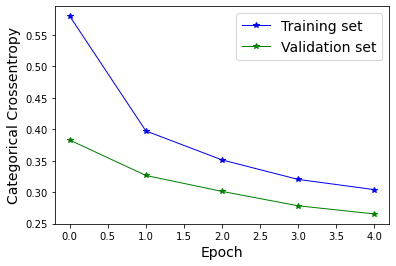

In [83]:
plt.plot(his.history['loss'], "b-*", linewidth=1, label="Training set")
plt.plot(his.history['val_loss'], "g-*", linewidth=1, label="Validation set")
plt.legend(loc="upper right", fontsize=14)
plt.xlabel("Epoch", fontsize=14)
plt.ylabel("Categorical Crossentropy", fontsize=14)
plt.show()

In [37]:
model.evaluate(X_test, y_test)

313/313 [==============================] - 2s 6ms/step - loss: 0.2854 - accuracy: 0.8922


[0.28542011976242065, 0.8921999931335449]

<ipython-input-64-fba37eaeb2bc>:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(cats)
<ipython-input-64-fba37eaeb2bc>:15: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(cats)
[[79.6  0.2  1.4  1.1  0.3  0.  16.8  0.   0.6  0. ]
 [ 0.  97.7  0.   1.5  0.3  0.   0.3  0.   0.2  0. ]
 [ 1.1  0.  86.9  0.8  6.   0.   5.2  0.   0.   0. ]
 [ 1.3  0.1  0.8 88.2  3.6  0.   5.6  0.   0.4  0. ]
 [ 0.1  0.1 11.1  2.4 82.4  0.   3.9  0.   0.   0. ]
 [ 0.   0.   0.   0.   0.  97.   0.   2.3  0.2  0.5]
 [ 7.3  0.   8.5  2.6 10.9  0.  69.8  0.   0.9  0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.  99.   0.   0.5]
 [ 0.2  0.1  0.2  0.2  0.4  0.2  0.   0.5 98.2  0. ]
 [ 0.   0.   0.   0.   0.   0.5  0.   6.1  0.  93.4]]


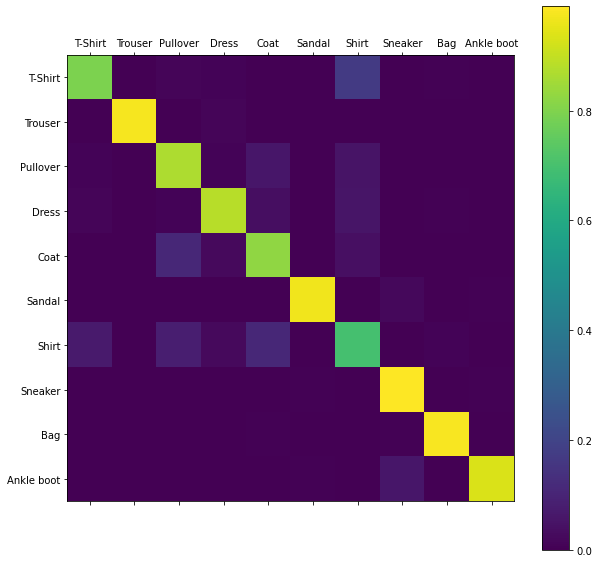

In [64]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt


y_pred = model.predict(X_test)
cm = confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
row_sums = cm.sum(axis=1, keepdims=True)
cm = cm / row_sums

cats = ['T-Shirt', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

fig, ax = plt.subplots(figsize=(10, 10))
im = ax.matshow(cm)
ax.set_xticklabels(cats)
ax.set_yticklabels(cats)
ax.set_xticks(range(len(cats)))
ax.set_yticks(range(len(cats)))
fig.colorbar(im, ax=ax)
print(cm * 100)

In [ ]:
import keras
from keras import layers
from keras.utils import to_categorical
import itertools

def create_model(hyper_parameters, X_train, y_train, epochs):

    model = keras.Sequential()

    model.add(
        layers.Conv2D(
            filters=hyper_parameters['1_conv2d_filters'],
            kernel_size=hyper_parameters['1_conv2d_kernel'],
            activation=hyper_parameters['activation'],
            input_shape=(28, 28, 1)
            )
        )

    model.add(layers.AveragePooling2D()) 

    model.add(
        layers.Conv2D(
            filters=hyper_parameters['2_conv2d_filters'],
            kernel_size=hyper_parameters['2_conv2d_kernel'],
            activation=hyper_parameters['activation']
        )
    )
        
    model.add(layers.AveragePooling2D())

    model.add(layers.Flatten())

    model.add(layers.Dense(units=hyper_parameters['dense1_units'], activation=hyper_parameters['activation']))
    model.add(layers.Dense(units=hyper_parameters['dense2_units'], activation=hyper_parameters['activation']))
    model.add(layers.Dense(units=10, activation='softmax'))

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics='accuracy')
    model.fit(X_train, y_train, epochs=epochs)

    return model

fashion_mnist = keras.datasets.fashion_mnist
(X_train_tuning, y_train_tuning), (X_test_tuning, y_test_tuning) = fashion_mnist.load_data()

#X_train_tuning = keras.utils.normalize(X_train_tuning) - Normalize
#X_test_tuning = keras.utils.normalize(X_test_tuning) - Normalize 

X_train_tuning = X_train_tuning.reshape((X_train_tuning.shape[0], 28, 28, 1))
y_train_tuning = to_categorical(y_train_tuning)
X_test_tuning = X_test_tuning.reshape((X_test_tuning.shape[0], 28, 28, 1))
y_test_tuning = to_categorical(y_test_tuning)

hyper_parameters_ranges = {
            '1_conv2d_filters': list(range(30, 41)),
            '1_conv2d_kernel': [(5,5), (3,3), (2, 2)],
            'activation': ['relu'],
            '2_conv2d_filters': list(range(30, 41)),
            '2_conv2d_kernel': [(5,5), (3,3), (2, 2)],
            'dense1_units':  list(range(85, 106)),
            'dense2_units': list(range(65, 75))
}

# Convert from dict of ranges to list of dicts
# https://stackoverflow.com/questions/38721847/how-to-generate-all-combination-from-values-in-dict-of-lists-in-python
keys, values = zip(*hyper_parameters_ranges.items())
hyper_parameters = [dict(zip(keys, v)) for v in itertools.product(*values)]

for hyper_parameter in hyper_parameters:
    model = create_model(hyper_parameter, X_train_tuning, y_train_tuning, 1)
    eval = model.evaluate(X_test_tuning, y_test_tuning)
    model.summary()

    result = f"""
    With hyper_parameters:
    {hyper_parameter}.
    Result: {eval}.

    """
    with open('results.txt', 'a') as file:
        file.write(result)

In [69]:
import itertools

hyper_parameters_ranges = {
            '1_conv2d_filters': list(range(30, 41)),
            '1_conv2d_kernel': [(5,5), (3,3), (2, 2)],
            'activation': ['relu'],
            '2_conv2d_filters': list(range(30, 41)),
            '2_conv2d_kernel': [(5,5), (3,3), (2, 2)],
            'dense1_units':  list(range(85, 106)),
            'dense2_units': list(range(65, 75))
}

hyper_parameters = [dict(zip(keys, v)) for v in itertools.product(*values)]
len(hyper_parameters)

NameError: name 'values' is not defined